In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '98667b6942f5455195b04a156d5519ca')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
results = search_images_bing(key, 'grizzly')
ims = results.attrgot('contentUrl')
len(ims)

150

In [6]:
dest = 'images/grizzly bear.jpg'
download_url(ims[0], dest)

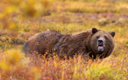

In [7]:
im = Image.open(dest)
im.to_thumb(128,128)

In [8]:
bear_types = 'grizzly','black','teddy'
path = Path('bears_new')

In [9]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [10]:
fns = get_image_files(path)
fns

(#412) [Path('bears_new/grizzly/00000003.jpg'),Path('bears_new/grizzly/00000005.jpg'),Path('bears_new/grizzly/00000001.jpg'),Path('bears_new/grizzly/00000007.jpg'),Path('bears_new/grizzly/00000009.jpg'),Path('bears_new/grizzly/00000008.jpg'),Path('bears_new/grizzly/00000004.jpg'),Path('bears_new/grizzly/00000006.jpg'),Path('bears_new/grizzly/00000011.jpg'),Path('bears_new/grizzly/00000012.jpg')...]

In [11]:
failed = verify_images(fns)
failed

(#12) [Path('bears_new/grizzly/00000055.jpg'),Path('bears_new/grizzly/00000063.jpg'),Path('bears_new/grizzly/00000103.jpg'),Path('bears_new/black/00000006.jpg'),Path('bears_new/black/00000143.jpg'),Path('bears_new/teddy/00000031.jpg'),Path('bears_new/teddy/00000037.jpg'),Path('bears_new/teddy/00000033.jpg'),Path('bears_new/teddy/00000076.jpg'),Path('bears_new/teddy/00000086.jpg')...]

In [12]:
failed.map(Path.unlink);

In [13]:
??verify_images

In [15]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [16]:
dls = bears.dataloaders(path)

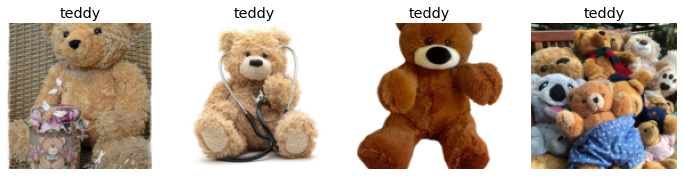

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

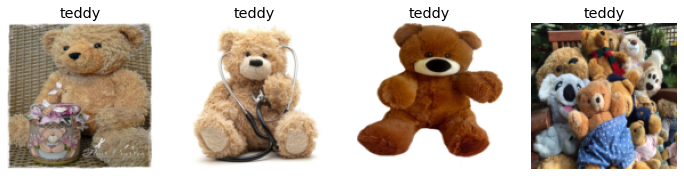

In [18]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

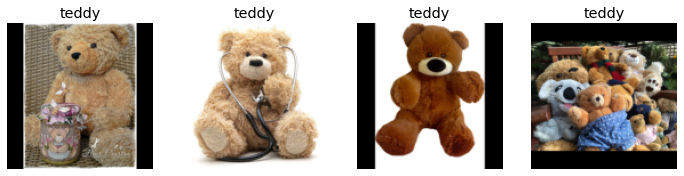

In [19]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

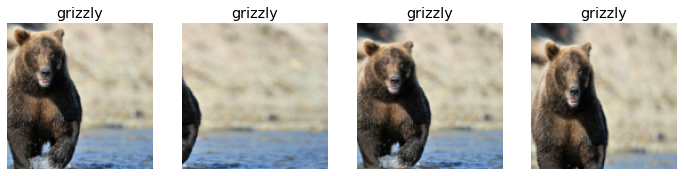

In [20]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

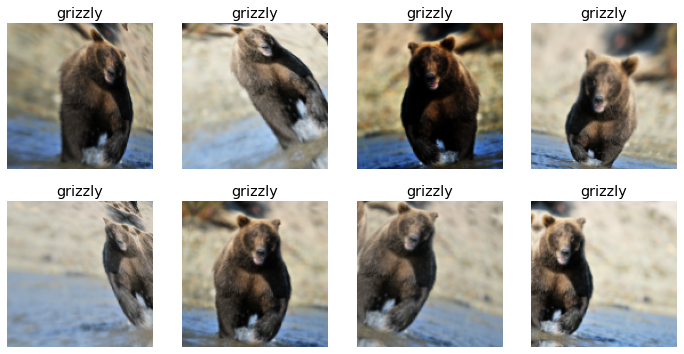

In [21]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [22]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.429639,0.073686,0.012500,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.160482,0.025416,0.012500,00:11
1,0.122061,0.013689,0.000000,00:10
2,0.084593,0.017977,0.012500,00:10
3,0.063300,0.017133,0.000000,00:11


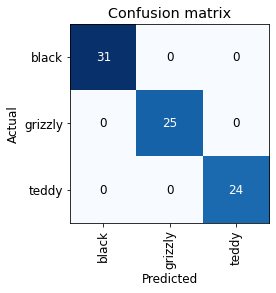

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [25]:
learn.export()

In [26]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [27]:
learn_inf = load_learner(path/'export.pkl')

In [28]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([1.5880e-06, 9.9999e-01, 9.0711e-06]))

In [29]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [32]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [33]:
img = PILImage.create(btn_upload.data[-1])

In [34]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [35]:
pred,pred_idx,probs = learn_inf.predict(img)

In [36]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [37]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [38]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [39]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [40]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [42]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 2.5 MB 34.6 MB/s eta 0:00:01
     |████████████████████████████████| 241 kB 65.6 MB/s eta 0:00:01
     |████████████████████████████████| 552 kB 74.8 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 7.7 MB/s  eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

nbdev 1.1.5 requires nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.7 OK
